# DISTRIBUITED ALGORITHMS - K-MEANS||

Project for the Physics of Data course Management and Analysis of Physics Dataset mod.B, academic year 2024-2025.

In [2]:
#Libraries used
import dask
import dask.array as da
from dask.distributed import Client
from dask_ml.preprocessing import StandardScaler
from dask_ml.cluster import KMeans
import numpy as np
from dask_ml.metrics import pairwise_distances
from dask_ml.metrics import pairwise_distances_argmin_min
from time import time
from timeit import default_timer as timer
from dask_ml.datasets import make_blobs
import pandas as pd
from dask.distributed import SSHCluster
import matplotlib.pyplot as plt
import pickle
import numba
from dask.distributed import SSHCluster, Client
from dask_ml.decomposition import PCA
from kmeans_parallel_dask import kmeans_parallel #our library for implementing kmeans|| in Dask
from matplotlib import colormaps
from matplotlib.colors import ListedColormap

In [4]:
# Configurazione Dask
dask.config.set({
    'distributed.comm.timeouts.connect': '60s',
    'distributed.comm.timeouts.tcp': '60s',
    'distributed.deploy.lost-worker-timeout': '30s',
})

def setup_cluster():
    """Setup del cluster SSH con tutte e 4 le VM"""
    VM_IPS = ['10.67.22.253','10.67.22.253', '10.67.22.93', '10.67.22.68', '10.67.22.80']
    
    print(f"Setting up SSH cluster with {len(VM_IPS) -1 } VMs...")
    
    cluster = SSHCluster(
        hosts=VM_IPS,
        connect_options={
            "username": "ubuntu",
            "client_keys": ["/home/ubuntu/MAPDB-13.pem"],
            "known_hosts": None,
            "connect_timeout": 30,
        },
        scheduler_options={
            "port": 8786,
            "dashboard_address": ":8787",
        },
        worker_options={
            "n_workers":1,
            "nthreads": 4,
            "memory_limit": "7.8GB",
        },
    )
    
    client = Client(cluster)
    print("Waiting for workers...")
    client.wait_for_workers(n_workers=4, timeout=30)
    
    print(f"✅ Cluster ready with {len(client.scheduler_info()['workers'])} workers")
    print(f"Dashboard: {client.dashboard_link}")
    
    return client, cluster

client, cluster=setup_cluster()

Setting up SSH cluster with 4 VMs...


2025-08-29 14:25:30,648 - distributed.deploy.ssh - INFO - 2025-08-29 14:25:30,647 - distributed.scheduler - INFO - State start
2025-08-29 14:25:30,652 - distributed.deploy.ssh - INFO - 2025-08-29 14:25:30,648 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-au_w7az9', purging
2025-08-29 14:25:30,654 - distributed.deploy.ssh - INFO - 2025-08-29 14:25:30,653 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.253:8786
2025-08-29 14:25:31,415 - distributed.deploy.ssh - INFO - 2025-08-29 14:25:31,414 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.253:45847'
2025-08-29 14:25:31,432 - distributed.deploy.ssh - INFO - 2025-08-29 14:25:31,435 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.93:42399'
2025-08-29 14:25:31,455 - distributed.deploy.ssh - INFO - 2025-08-29 14:25:31,456 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.80:45123'
2025-08-29 14:25:31,461 - d

Waiting for workers...
✅ Cluster ready with 4 workers
Dashboard: http://10.67.22.253:8787/status


In [5]:
# Connect the Dask client to the existing cluster using the scheduler's address
#client = Client("tcp://localhost:8786")
client = Client(cluster)

# Print the cluster configuration
scheduler_info = client.scheduler_info()
workers_info = scheduler_info['workers'] 
# Get the information for the first worker in the cluster
worker = list(workers_info.values())[0]
n_workers = len(workers_info)
n_threads = worker['nthreads']

print(f'client dashboard link: {client.dashboard_link}')
print(f"Cluster setup with {n_workers} workers, each with {n_threads} threads")
client

client dashboard link: http://10.67.22.253:8787/status
Cluster setup with 4 workers, each with 4 threads


<Client: 'tcp://10.67.22.253:8786' processes=4 threads=16, memory=29.06 GiB>

## K-means||

The K-Means method is widely used for unsupervised clustering tasks. One common technique for weight initialization in K-Means is known as K-Means++, though it is primarily a sequential algorithm. A scalable version, referred to as K-Means∥, is introduced and described in detail in the paper available at https://arxiv.org/pdf/1203.6402.

Parallel K-Means enhances the K-Means++ algorithm by distributing computations across multiple processors, which speeds up the clustering of large datasets. This approach allows for efficient scaling and faster convergence. The proposed method focuses on improving the initialization procedure and then employs Lloyd's scalable algorithm.
Below, we explain the algorithm for the initialization phase of Parallel K-Means (which uses K-Means++) and Lloyd's algorithm.

## Test custom implementation on syntetic datasets

### Test 1: speed test
We will illustrate how, for large enough datasets (otherwise dask otherheads become dominant), the parallel paragidm will provide a faster implementation of kmeans than a sequential procedure

In [10]:
# ==============================
# KMeans benchmark (Dask-safe)
# ==============================
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dask.array as da
from dask_ml.preprocessing import StandardScaler           # <-- Dask-ML scaler (keeps Dask)
from dask_ml.cluster import KMeans as DaskKMeans
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.datasets import make_blobs

# your custom impl must accept a Dask array X
from kmeans_parallel_dask import kmeans_parallel

# -------- dataset factory using your chunk sizing idea --------
def generate_data(N, k, dim, seed, target_mb):
    """Return Dask array X (N, dim) and NumPy y, with row-wise chunking."""
    B = 8  # float64
    rows_per_chunk = max(1, math.floor((target_mb * 1024 * 1024) / (dim * B)))
    chunks = (rows_per_chunk, dim)

    # build as NumPy then wrap as Dask with desired chunks (fast & simple)
    X_np, y_np = make_blobs(n_samples=N, centers=k, n_features=dim, random_state=seed)
    X = da.from_array(X_np, chunks=chunks)     # <-- Dask array from the start
    return X, y_np, chunks

# -------- benchmark --------
def benchmark_kmeans(N_values, R=3, k=4, n_feat=5000, target_mb=50, seed=42):
    """
    For each N in N_values, run R repetitions of:
      - custom kmeans_parallel (Dask)
      - Dask-ML KMeans
      - sklearn KMeans (on NumPy)
    Returns a pandas DataFrame with per-run times and also plots mean±std.
    """
    rows = []
    for N in N_values:
        print(f"\n=== N={N} ===")
        for r in range(R):
            # ---- data (Dask) ----
            X, y, chunks = generate_data(N=N, k=k, dim=n_feat, seed=seed + r, target_mb=target_mb)

            # ---- scale (Dask -> stays Dask) ----
            scaler = StandardScaler(with_mean=True, with_std=True)
            X_norm = scaler.fit_transform(X)           # Dask array
            X_norm = X_norm.persist()                  # materialize graph in cluster memory

            # ---- custom (Dask) ----
            t0 = time.time()
            _ = kmeans_parallel(X=X_norm, k=k, l=2)
            t1 = time.time()
            rows.append({"N": N, "method": "CustomKMeans", "time": t1 - t0, "rep": r})

            # ---- Dask-ML (Dask) ----
            t0 = time.time()
            dask_km = DaskKMeans(n_clusters=k, init="k-means||",
                                 init_max_iter=100, oversampling_factor=2,
                                 random_state=seed + r)
            _ = dask_km.fit(X_norm)
            t1 = time.time()
            rows.append({"N": N, "method": "DaskMLKMeans", "time": t1 - t0, "rep": r})

            # ---- sklearn (NumPy) ----
            X_np = X_norm.compute()                    # move to driver for sklearn
            t0 = time.time()
            sk_km = SklearnKMeans(n_clusters=k, init="k-means++", random_state=seed + r)
            _ = sk_km.fit(X_np)
            t1 = time.time()
            rows.append({"N": N, "method": "SklearnKMeans", "time": t1 - t0, "rep": r})

            # free driver memory sooner
            del X_np

    df = pd.DataFrame(rows)

    # ---- plot mean ± std ----
    fig, ax = plt.subplots(figsize=(10, 6))
    for method, color in zip(["CustomKMeans", "DaskMLKMeans", "SklearnKMeans"],
                             ["tab:blue", "tab:orange", "tab:green"]):
        sub = df[df.method == method].groupby("N")["time"]
        means, stds = sub.mean(), sub.std()
        ax.errorbar(means.index, means.values, yerr=stds.values, marker="o",
                    capsize=4, label=method, color=color)

    ax.set_xlabel("Number of samples (N)")
    ax.set_ylabel("Execution time (s)")
    ax.set_title(f"KMeans benchmark (features={n_feat}, R={R}, target≈{target_mb}MB/chunk)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    return df



=== N=10 ===

=== N=1120 ===

=== N=2230 ===

=== N=3340 ===

=== N=4450 ===

=== N=5560 ===

=== N=6670 ===

=== N=7780 ===

=== N=8890 ===

=== N=10000 ===


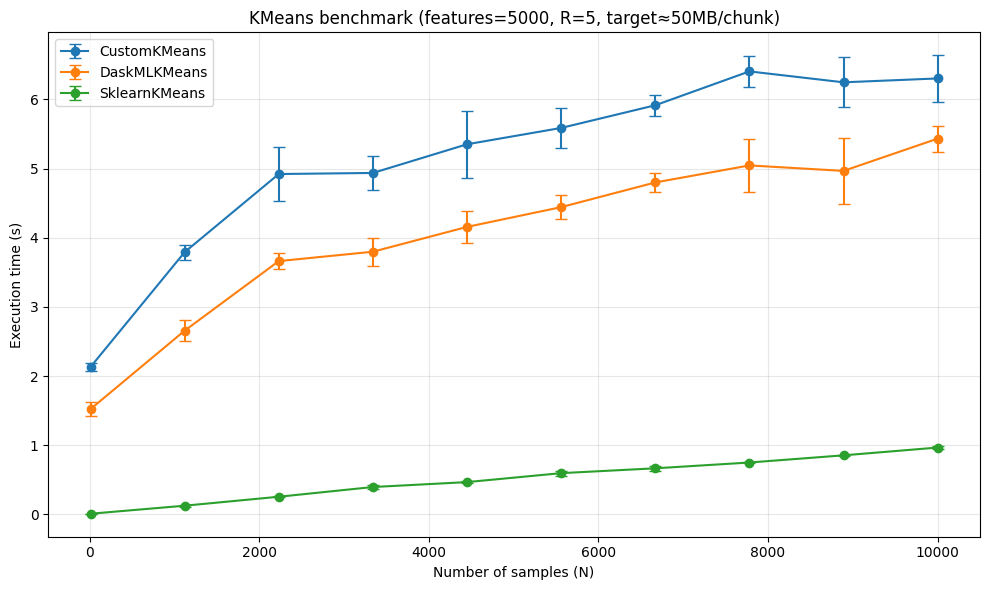

In [25]:
# Run test benchmark on small sizes
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # We want to ignore the warning relative to the slowdown caused by
#materializing all the data in one machine when executing the sequential algorithm
benchmark_results = benchmark_kmeans(N_values=np.linspace(10, 10000, 10, dtype=int), R=5)

### Test 2: handling a syntetic, large dataset

In [ ]:
# ==============================
# Generazione dataset sintetico
# ==============================

N=100000 #number of points
k=4 # number of centers
n_feat= 5000 #number of features
seed=42

Target= 50 # target (MB) per chunck
B=8 #bytes per element
rows_per_chunk = int((Target * 1024 * 1024) / (n_feat * B))  #check !!!!!!!!!!
chunks = (rows_per_chunk,n_feat)  # row-wise chucnking, do not divide the features

def generate_data(N=N, k=k, dim=n_feat, random_state=seed,chunks=chunks):
    X, y = make_blobs(n_samples=N, centers=k, n_features=dim, random_state=random_state, chunks=chunks) #synthetic data, true label
    return X, y

In [142]:
#Generate synthetic dataset
data, labels=generate_data(N=N)

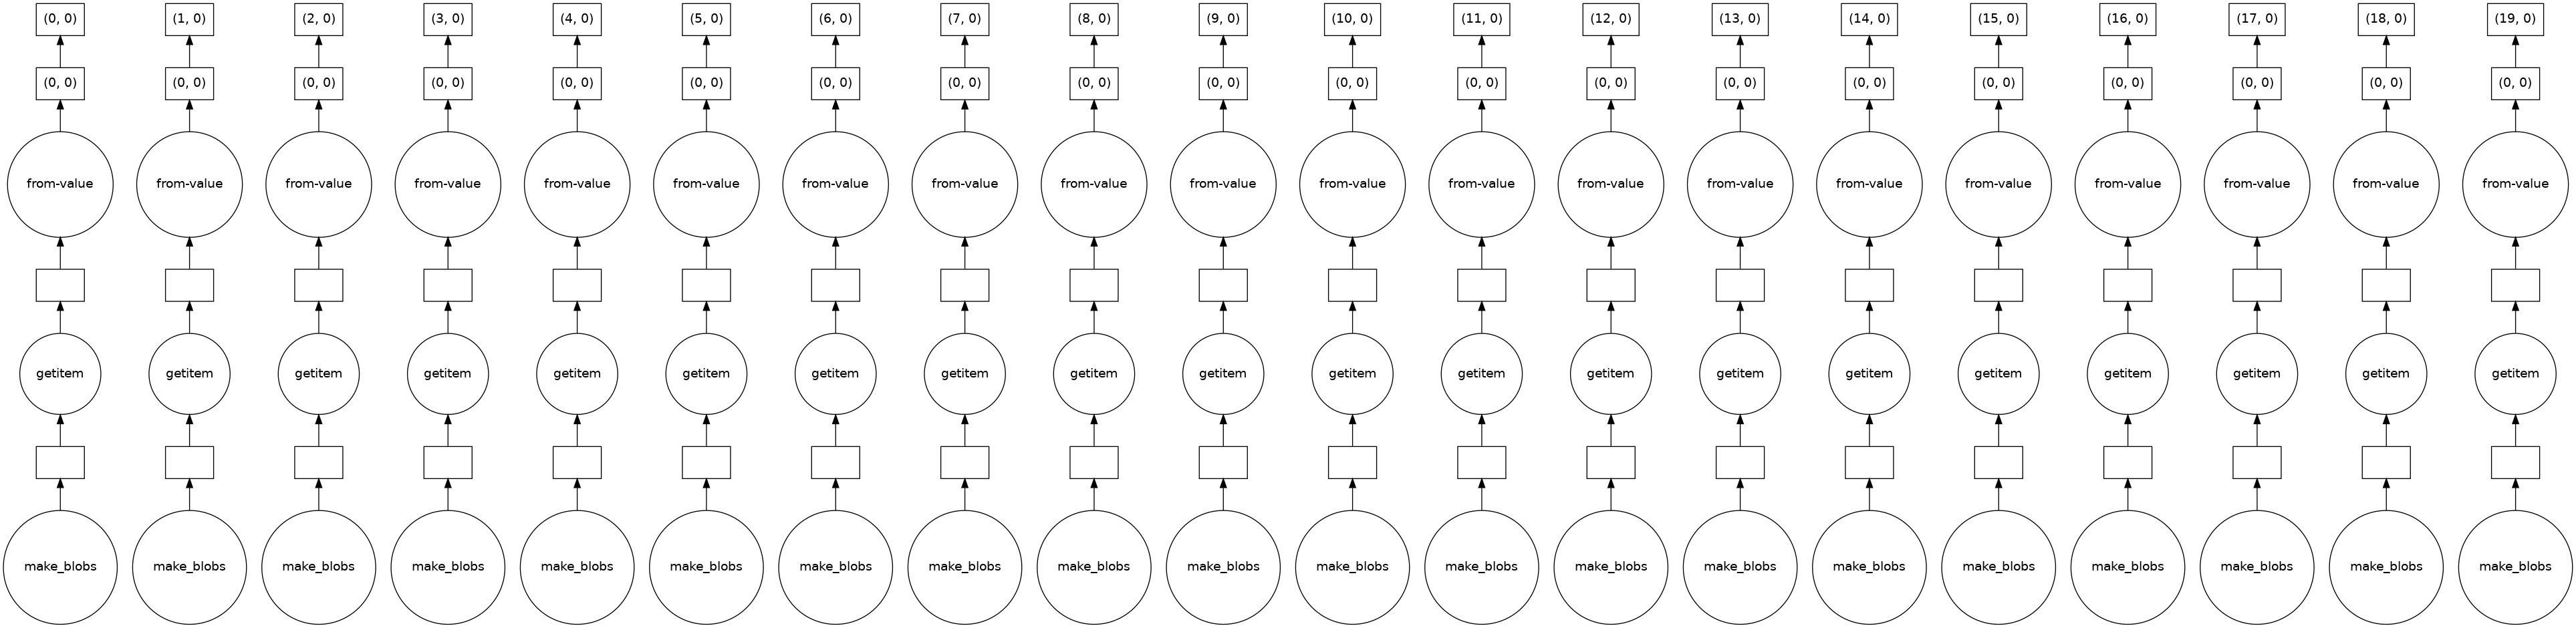

In [143]:
#Visualize the associated computational graph
data.visualize()

In [144]:
#Inspect the data
data.persist()

dask.array<concatenate, shape=(100000, 5000), dtype=float64, chunksize=(5242, 5000), chunktype=numpy.ndarray>

In [145]:
# Normalize the data before clustering

# X_sparse: dask.array of sparse blocks (e.g. scipy.sparse.csr in each chunk, or sparse.COO)

scaler = StandardScaler(with_mean=True, with_std=True)
data_normalized = scaler.fit_transform(data)
del data

"""
mean = data.mean(axis=0, split_every=8)
std  = data.std(axis=0,  ddof=1, split_every=8)
data_normalized = ((data - mean) / std)
del data
"""

"""
scaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix
%time data_normalized = scaler.fit_transform(data)
del data
"""

'\nscaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix\n%time data_normalized = scaler.fit_transform(data)\ndel data\n'

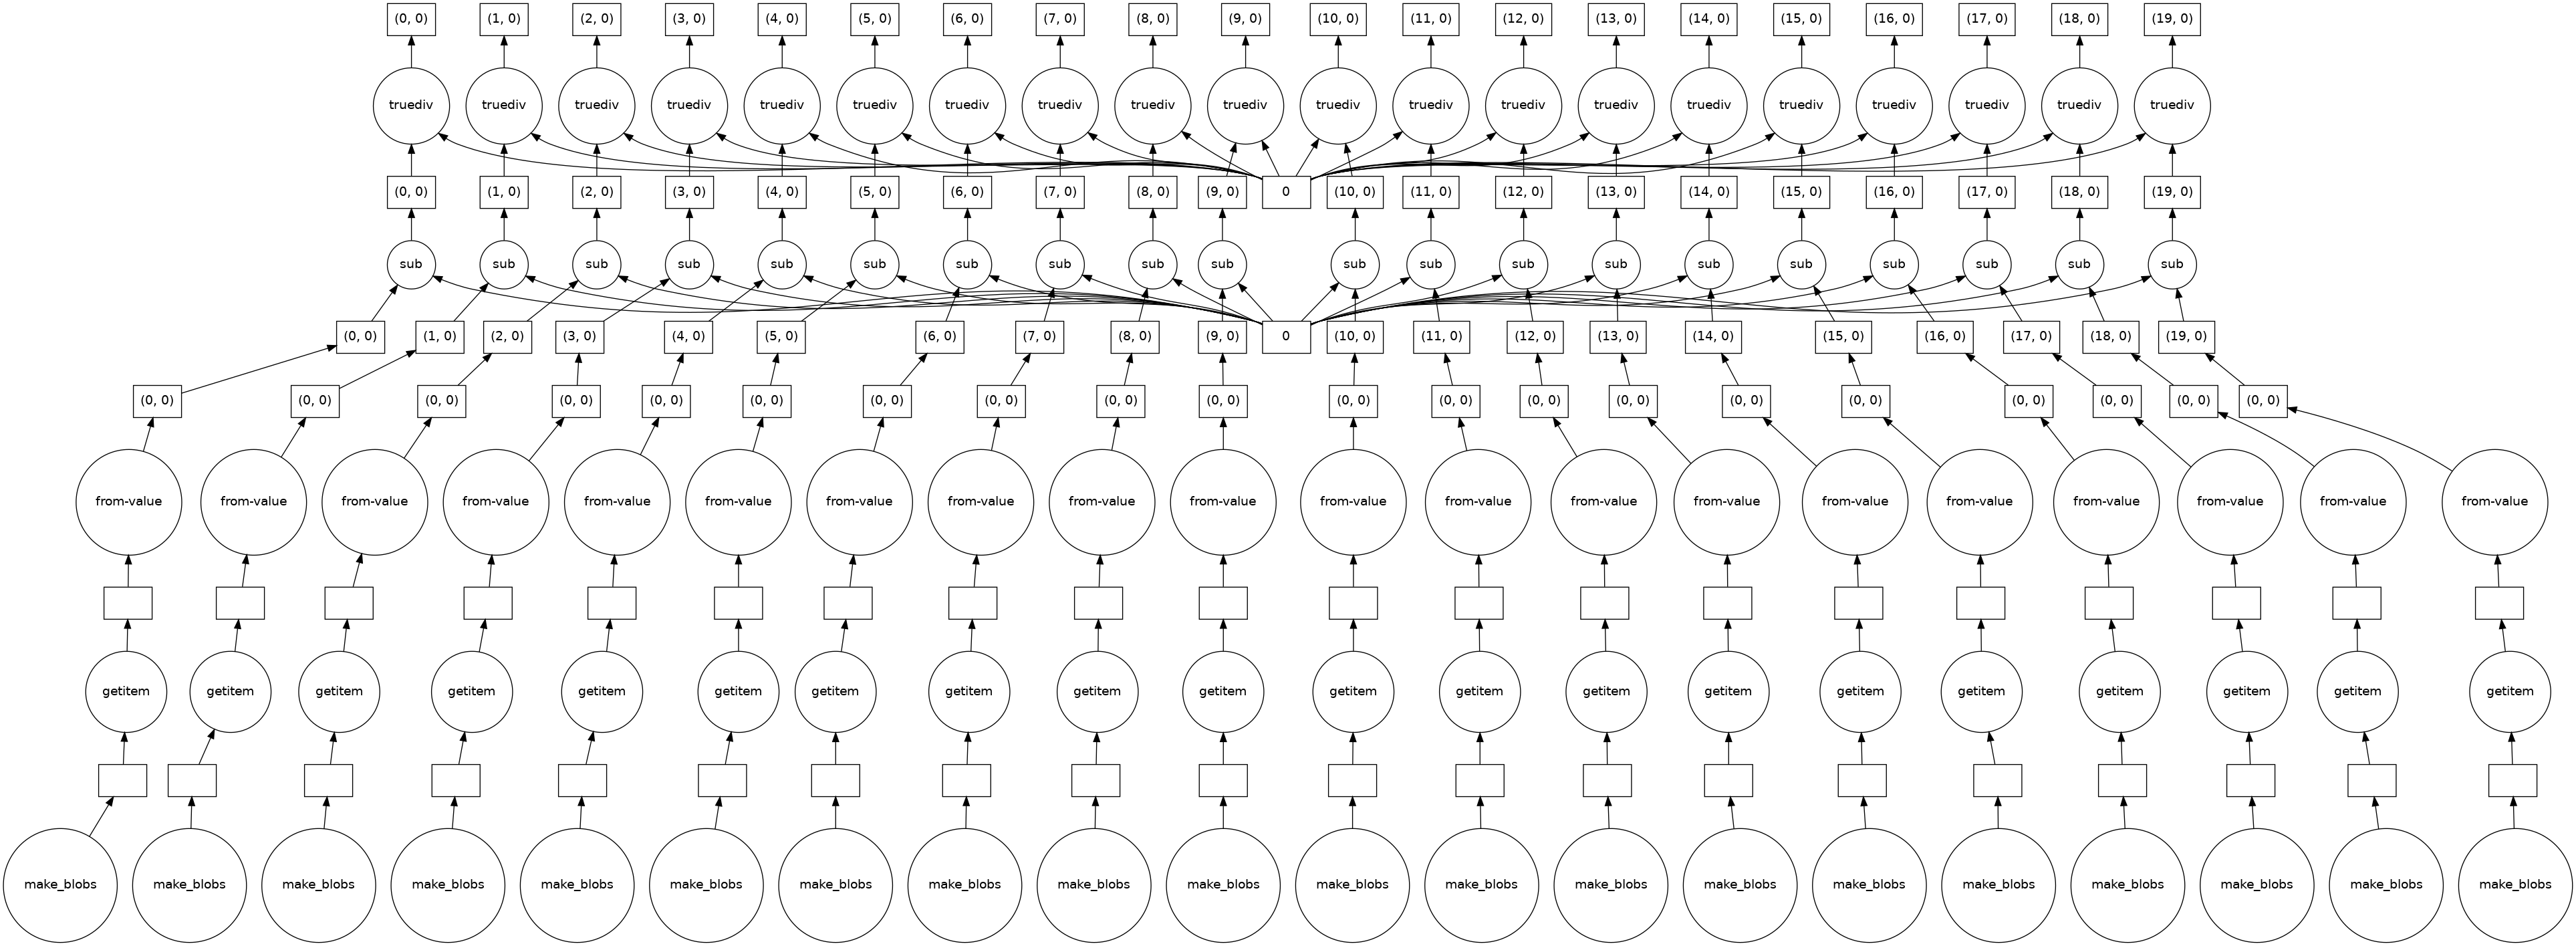

In [146]:
data_normalized.visualize()

In [147]:
data_normalized=data_normalized.persist() #Make data persistent to speed up future computation
data_normalized

dask.array<truediv, shape=(100000, 5000), dtype=float64, chunksize=(5242, 5000), chunktype=numpy.ndarray>

In [148]:
from dask.distributed import performance_report


#Our implementation
with performance_report(filename="kmean_our.html"):  
    %time synt_labels, synt_centroids = kmeans_parallel(X=data_normalized, k=k, l=2)

CPU times: user 1.12 s, sys: 79.7 ms, total: 1.2 s
Wall time: 15.3 s


In [149]:
#Dask's implementation
%time dask_ml_kmeans = KMeans(n_clusters=k,init="k-means||", init_max_iter=100, oversampling_factor=2, random_state=42).fit(data_normalized)    
data_dask_centers = dask_ml_kmeans.cluster_centers_
data_dask_labels = dask_ml_kmeans.labels_

CPU times: user 1.44 s, sys: 73.2 ms, total: 1.51 s
Wall time: 13.6 s


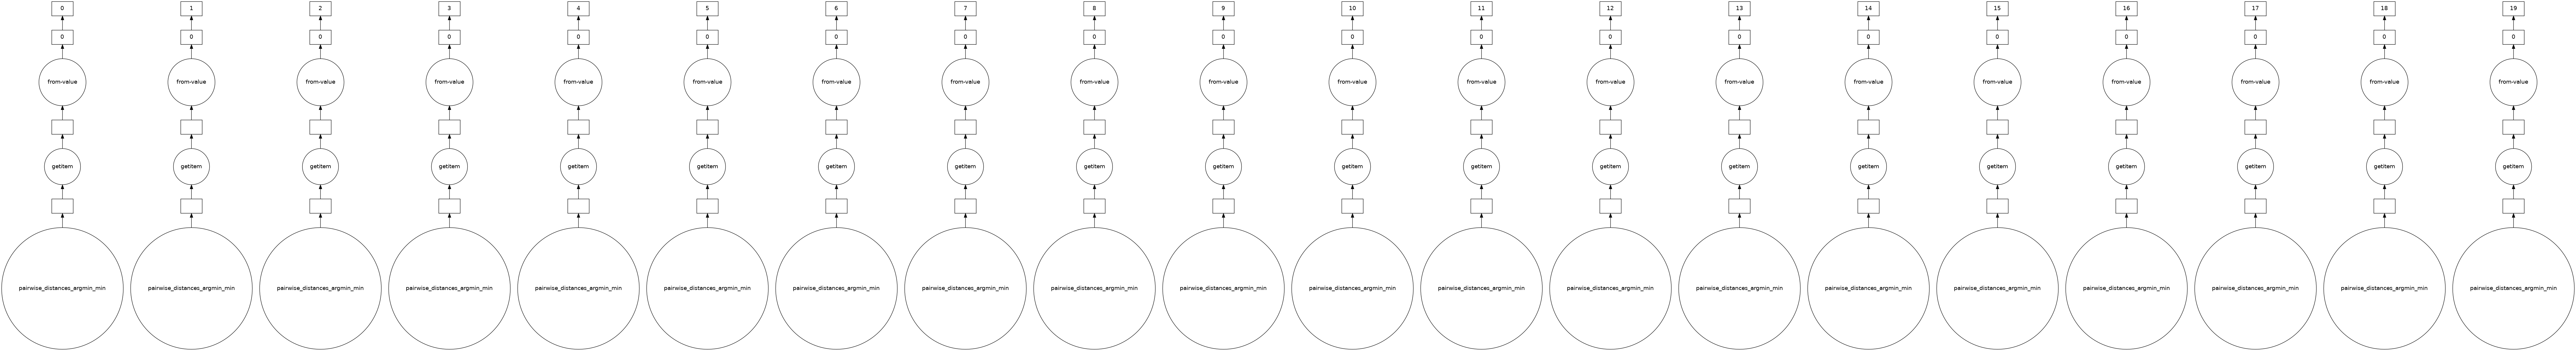

In [150]:
synt_labels.visualize()

In [151]:
#Plot

from IPython.display import IFrame
# Display the HTML report in Jupyter
IFrame(src="kmean_our.html", width=1280, height=720)

In [152]:
def plot_clusters_by_row(X_pca, cluster_labels, centroids, pca, true_labels=None, title_prefix='Cluster'):
    """
    Plot one row per cluster:
    - left: predicted cluster points + centroid
    - right: same points colored the same, showing their true label

    Parameters
    ----------
    X_pca : np.ndarray, shape (n_samples, 2)
        PCA-projected data to plot.
    cluster_labels : np.ndarray, shape (n_samples,)
        Predicted labels (e.g., from KMeans).
    centroids : np.ndarray, shape (n_clusters, n_features)
        Centroids to project and plot.
    pca : PCA object
        Fitted PCA used to project centroids.
    true_labels : np.ndarray, shape (n_samples,), optional
        True labels to show in the right panel (colors will match predicted).
    title_prefix : str
        Prefix for plot titles (e.g. 'KMeans', 'Custom', etc.).
    """

    # Project centroids into PCA space
    centroids_pca = pca.transform(np.asarray(centroids))

    # Sort centroids and relabel cluster IDs
    sorted_idx = np.lexsort(centroids_pca.T)
    centroids_pca_sorted = centroids_pca[sorted_idx]
    remap = {old: new for new, old in enumerate(sorted_idx)}
    cluster_labels_sorted = np.vectorize(remap.get)(cluster_labels)

    # Prepare consistent colors
    K = len(centroids_pca_sorted)
    cmap = plt.cm.get_cmap("tab10", K)

    for i in range(K):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

        idx = np.where(cluster_labels_sorted == i)[0]
        X_cluster = X_pca[idx]
        color = cmap(i)

        # Left: Predicted cluster i
        ax[0].scatter(X_cluster[:, 0], X_cluster[:, 1], color=color, s=5, label=f'Cluster {i}')
        ax[0].scatter(centroids_pca_sorted[i, 0], centroids_pca_sorted[i, 1],
                      marker='x', s=100, color='black', label='Centroid')
        ax[0].set_title(f'{title_prefix} - cluster {i+1}')
        ax[0].legend()

        # Right: Same points, but optionally show their true label (in same color)
        if true_labels is not None:
            ax[1].scatter(X_cluster[:, 0], X_cluster[:, 1], color=color, s=5)
            ax[1].set_title(f'True labels - cluster {i+1} ')
        else:
            ax[1].scatter(X_cluster[:, 0], X_cluster[:, 1], color=color, s=5)
            ax[1].set_title('True labels not available')

        for a in ax:
            a.set_xlabel("PC1")
            a.set_ylabel("PC2")
            a.grid(True, alpha=0.3)

        plt.suptitle(f'{title_prefix} {i} — PCA projection')
        plt.tight_layout()
        plt.show()

In [153]:
def plot_all_clusters(
    X_pca,
    label_sets,
    titles,
    centroid_sets=None,
    pca=None,
    colormap="tab10"
):
    """
    Plot multiple clusterings in a row with consistent coloring and optional centroids.

    Parameters
    ----------
    X_pca : np.ndarray
        2D PCA projection of the dataset (n_samples, 2)
    label_sets : list of np.ndarray
        List of label arrays (e.g., [synt_labels, dask_labels, true_labels])
    titles : list of str
        Titles for each subplot
    centroid_sets : list of arrays or None
        List of centroid arrays (same length as label_sets), or None
    pca : fitted PCA object or None
        Used to project centroids (if provided)
    colormap : str
        Name of a Matplotlib colormap (e.g., "tab10", "Set3", "Paired")
    """
    n_plots = len(label_sets)
    fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), sharex=True, sharey=True)

    if centroid_sets is None:
        centroid_sets = [None] * n_plots

    for i, (labels, title, centroids) in enumerate(zip(label_sets, titles, centroid_sets)):
        ax = axs[i]
        unique_labels = np.unique(labels)
        K = len(unique_labels)

        # Slice the colormap to K colors
        base_cmap = colormaps.get_cmap(colormap)
        colors = base_cmap(np.linspace(0, 1, K))
        cmap = ListedColormap(colors)

        for j, lbl in enumerate(unique_labels):
            idx = labels == lbl
            ax.scatter(X_pca[idx, 0], X_pca[idx, 1], color=cmap(j), s=5, label=f"Cluster {lbl+1}")

        # project and plot centroids if provided
        if centroids is not None and pca is not None:
            centroids_pca = pca.transform(np.asarray(centroids))
            ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                       marker='x', s=100, color='black', label='Centroids')

        ax.set_title(title)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(True, alpha=0.3)
        ax.legend(markerscale=2, fontsize=7)

    plt.tight_layout()
    plt.show()

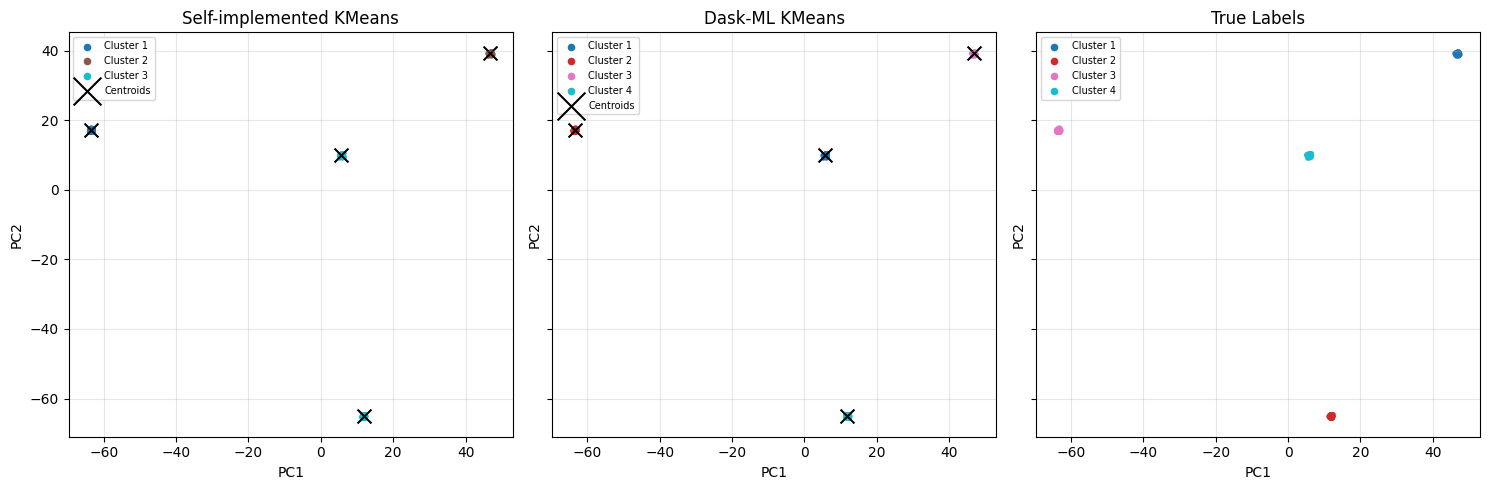

In [154]:
plot_all_clusters(
    X_pca=X_pca,
    label_sets=[synt_labels_sub, data_dask_labels_sub, labels_sub],
    titles=["Self-implemented KMeans", "Dask-ML KMeans", "True Labels"],
    centroid_sets=[synt_centroids, data_dask_centers, None],
    pca=pca,
    colormap="tab10"
)

/tmp/ipykernel_119738/2711090679.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", K)


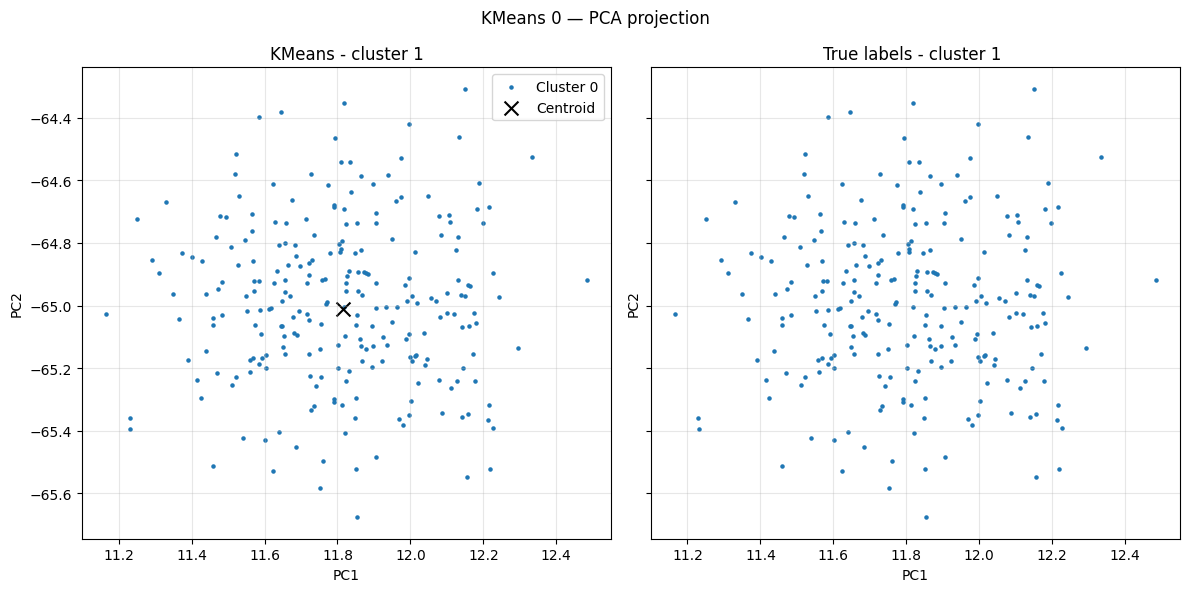

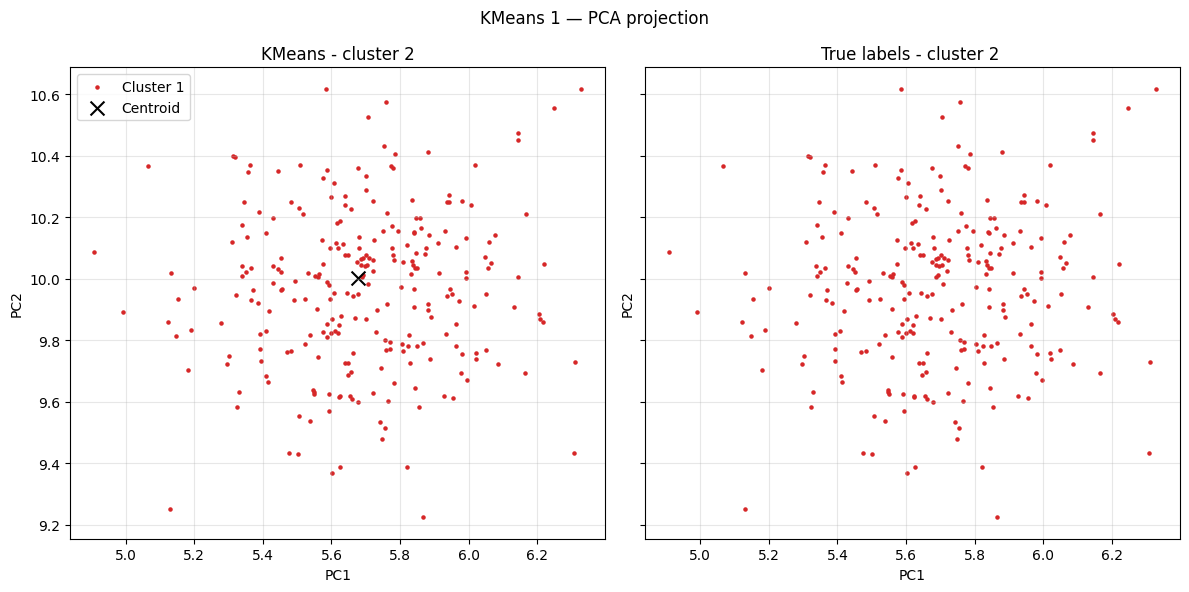

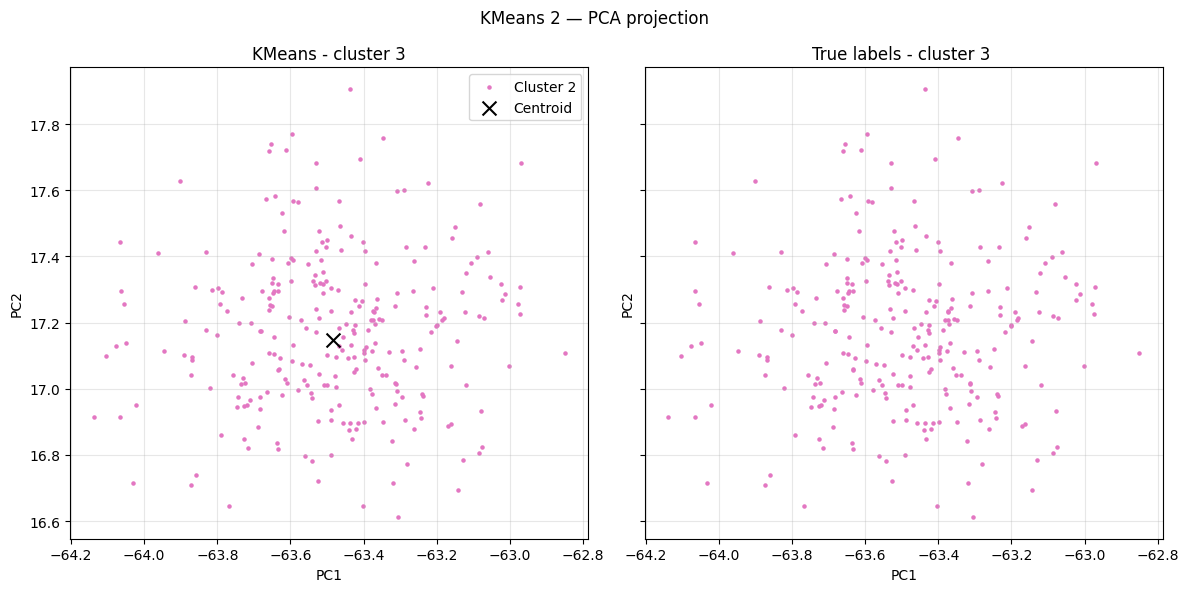

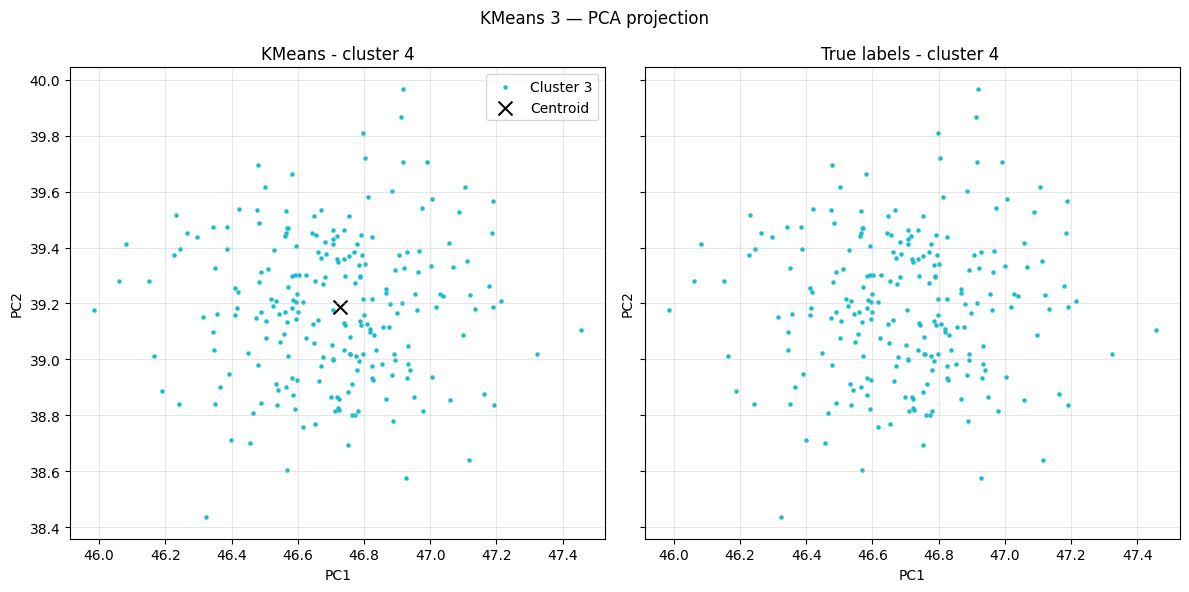

In [155]:
import numpy as np
from sklearn.decomposition import PCA
import dask.array as da

# Parameters
subset = int(data_normalized.shape[0] / 100)
N_FIT = 10000
rng = np.random.default_rng(0)

# Step 1: Sample & fit PCA
n_total = int(data_normalized.shape[0])
idx_np = rng.choice(n_total, size=N_FIT, replace=False)
X_sample = da.take(data_normalized, idx_np, axis=0).compute()

pca = PCA(n_components=2, random_state=0)
pca.fit(X_sample)

# Step 2: Transform subset
X_subset = data_normalized[:subset].compute()
X_pca = pca.transform(X_subset)

# Step 3: Extract labels and centroids
try:
    synt_labels_sub = synt_labels[:subset].compute()
    synt_centroids_np = np.asarray(getattr(synt_centroids, "compute", lambda: synt_centroids)())
    labels_sub = labels[:subset].compute()
except Exception as e:
    raise RuntimeError(f"Data loading failed: {e}")


# Step 4: Plot with the reusable function

#Plot Self implemented Kmeans vs True label for each cluster
plot_clusters_by_row(
    X_pca=X_pca,
    cluster_labels=synt_labels_sub,
    centroids=synt_centroids_np,
    pca=pca,
    true_labels=labels_sub,
    title_prefix="KMeans"
)

/tmp/ipykernel_119738/2711090679.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", K)


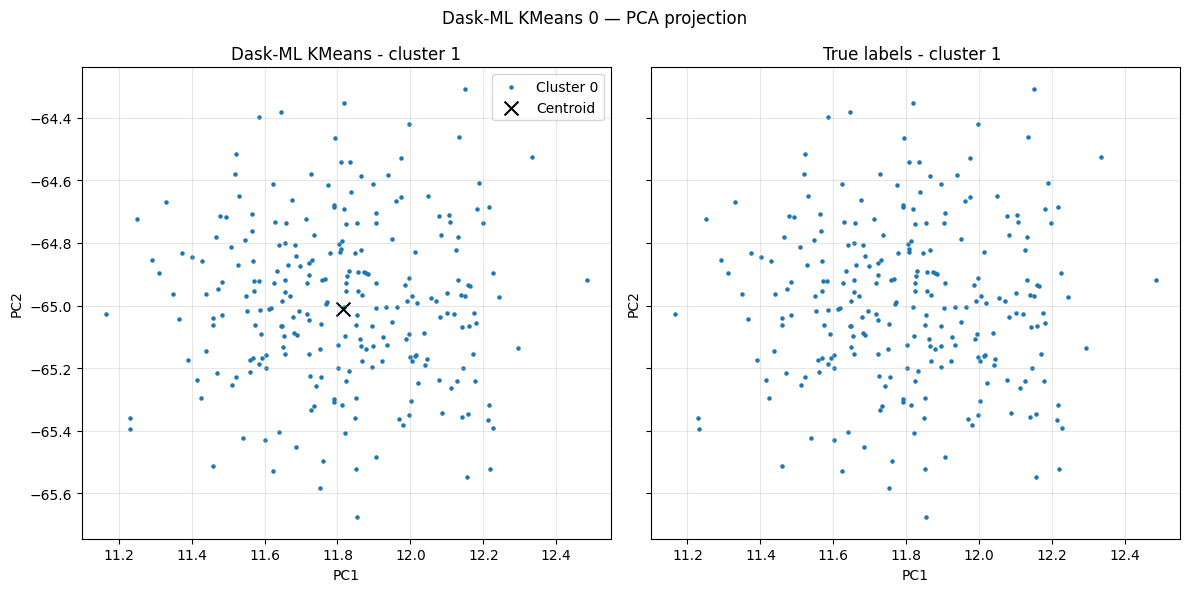

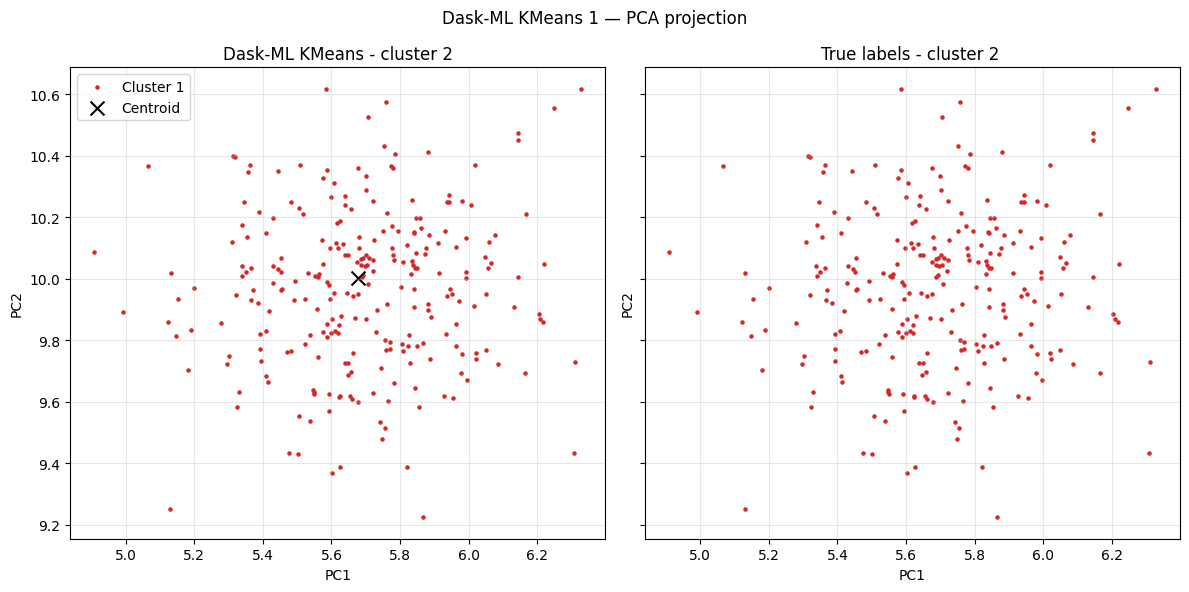

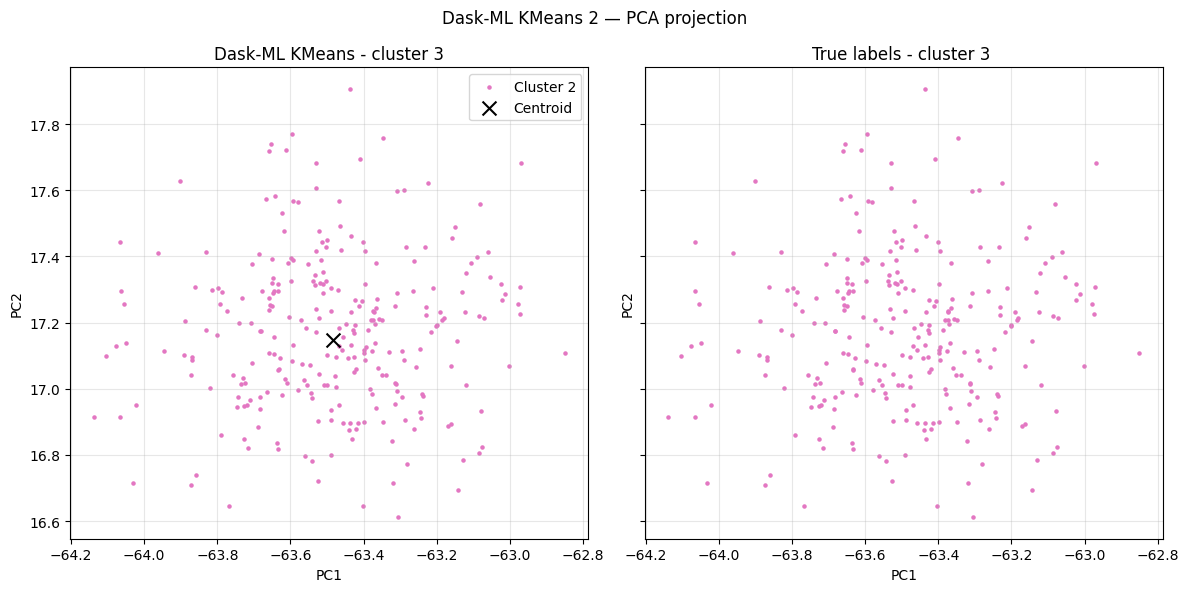

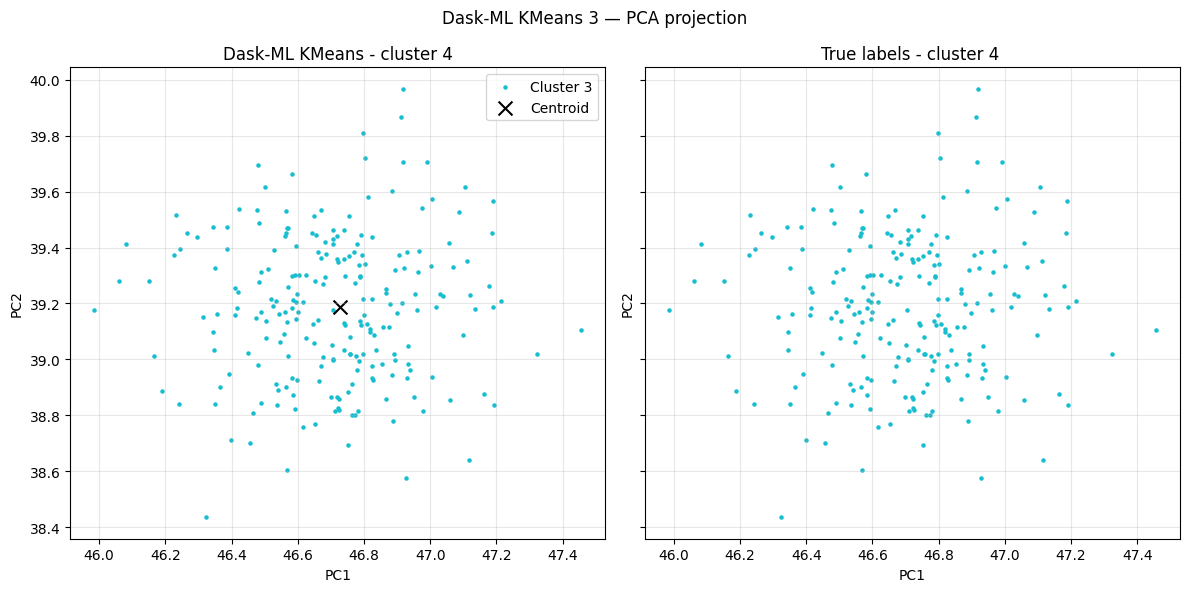

In [156]:
# Test for dask library kmeans|| clustering vs true label for each cluster
try:
    data_dask_labels_sub = data_dask_labels[:subset].compute()
    data_dask_centroids_np = np.asarray(getattr(data_dask_centers, "compute", lambda: data_dask_centers)())
    labels_sub = labels[:subset].compute()
except Exception as e:
    raise RuntimeError(f"Data loading failed: {e}")

plot_clusters_by_row(
    X_pca=X_pca,
    cluster_labels=data_dask_labels_sub,
    centroids=data_dask_centroids_np,
    pca=pca,
    true_labels=labels_sub,
    title_prefix="Dask-ML KMeans"
)

In [27]:
#Testing equality of the centroids
# Define a function to sort centroids for consistency
def sort_centroids(centroids):
    # Use np.lexsort to sort the centroids by all dimensions
    sorted_indices = np.lexsort(centroids.T)
    return centroids[sorted_indices]

# Sort both sets of centroids
sorted_dask_centers = sort_centroids(data_dask_centers)
sorted_synt_centroids = sort_centroids(synt_centroids)

# Check for equality with np.allclose
equality = np.allclose(sorted_dask_centers, sorted_synt_centroids, atol=1e-10)
print(f"Equality between Dask-ML KMeans and Custom KMeans: {equality}")

Equality between Dask-ML KMeans and Custom KMeans: True


In [128]:
#here we will close the cluster because for the benchmarking we will need to create others cluster with differents configurations
# Shut down the Dask cluster, terminating all associated workers and releasing resources.
cluster.close()

# Close the connection between the Dask client and the cluster to ensure no further communication.
client.close()